# Disky Halo Visualizations

Brief analysis of angle between halo rotation axes for "disky" and "nondisky" halos. Provides code for visualizing a single halo and their axes - both 3D scatterplot and 2D kde.

In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py
from os.path import exists 
from scipy import stats
from numpy.linalg import inv
import seaborn as sns
import pandas as pd
from scipy.spatial.transform import Rotation as R

sim = 'L35n2160TNG'
basePath = '/home/tnguser/sims.TNG/' + sim + '/output'

# Halos in Neil Ash's catalog
catalogue_path = '/home/tnguser/postprocessing/halocatalogues/' + sim + '.npy'
naive_halos = np.load(catalogue_path)
main_subhalos = np.load('/home/tnguser/postprocessing/halocatalogues/' + sim + '_mainSubhalos.npy') 

# CHANGE TO DESIRED FILE PATHS
anglePath = '/home/tnguser/postprocessing/angles/' + sim + '/00_15Rvir/'
spin_path = '/home/tnguser/postprocessing/angular_momentum/' + sim + '/00_15kpc/'
pattern_path =  '/home/tnguser/postprocessing/pattern_speeds/' + sim + '/00_06Rvir/'
principal_path =  '/home/tnguser/postprocessing/principal_axes/' + sim + '/00_06Rvir/'

snap = 99
startSnap = 75

### Helper Functions

In [2]:
def getAngle(vec1, vec2):
    return np.degrees(np.arccos(np.dot(vec1, vec2)))

def getRotationAxis(snap, startStops, Raxis):
    for idx, (first,second) in enumerate(startStops):
        if (snap >= first and snap < second):
            return Raxis[idx]
    return Raxis[-1]

### Finds subfindIDs of halos in halo catalog which are "disky" and "nondisky". Retrieves angles

In [ ]:
filename = "./stellar_circs.hdf5" # supplementary stellar circularity information
hf=h5py.File(filename,'r')
circ_subfindID = hf['Snapshot_99']['SubfindID']
circ07 = hf['Snapshot_99']['CircAbove07Frac']

disky_temp = circ_subfindID[np.where(np.array(circ07) > 0.5)] # definition of "disky" halos
nondisky_temp = circ_subfindID[np.where(np.array(circ07) <= 0.5)]

diskyIDs = np.intersect1d(disky_temp,main_subhalos)
nondiskyIDs = np.intersect1d(nondisky_temp,main_subhalos)

print("Number of disky halos ", len(diskyIDs))
print("Number of nondisky halos ",len(nondiskyIDs))

Retrieves angles between angular momentum axis and figure rotation axis. Angle calculated in CalculateAngularMomentum.

In [4]:
disky_angles = []
nondisky_angles = []

for subfindID in diskyIDs:
    GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr']
    angle_file = anglePath +'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap)
    if exists(angle_file):
        disky_angles.append(np.load(angle_file,allow_pickle=True)[24])
        
for subfindID in nondiskyIDs:
    GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr']
    angle_file = anglePath +'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap)
    if exists(angle_file):
        nondisky_angles.append(np.load(angle_file,allow_pickle=True)[24]) 

## Visualizations

### Population Statistics of Axis Angles

In [ ]:
# Histogram of percent of stars located in the disk

circ07_disky = []
for i,ID in enumerate(diskyIDs):
    temp = circ07[np.where(ID == circ_subfindID)]
    circ07_disky.append(temp[0])

plt.hist(circ07_disky)
plt.xlabel('% of stars in disk')

max_disky = max(circ07_disky)
max_disky_ID = circ_subfindID[np.where(circ07 == max_disky)][0]
max_disky_GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=max_disky_ID)['SubhaloGrNr']
print('max disky halo: GrNr ', max_disky_GrNr)

In [4]:
### KDE functions

# Top hat kernel
def K(u):
    if (u<=1):
        return 1/2
    else:
        return 0
    
# Epanechinkov kernel
def K(u):
    if (u <= 1):
        return 3/4*(1-u**2)
    else:
        return 0

def KDE(x_input,h,data):
    output = np.zeros(len(x_input))
    for i,x in enumerate(x_input):
        for j, xj in enumerate(data):
            output[i] += 1/h*K(np.abs((x-xj)/h))
        output[i] = output[i]/len(data)
    return output

def silverman(data):
    std = np.std(data)
    m = stats.iqr(data)/1.34
    if (std) < m:
        m = std
    return 0.9*m*(len(data))**(-1/5)

Text(0.5, 1.0, 'KDE with Epanechinkov kernel')

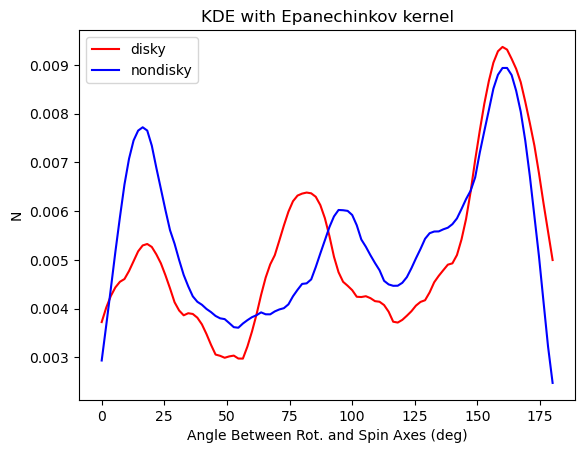

In [43]:
# Basic KDE of disky and non-disky angles between figure rotation & angular momentum axes

h_disky = silverman(disky_angles)
h_nondisky = silverman(nondisky_angles)

x = np.linspace(0,180,100)

KDE_disky = KDE(x, h_disky, disky_angles)
KDE_nondisky = KDE(x, h_nondisky, nondisky_angles)

plt.plot(x,KDE_disky,'r',label='disky')
plt.plot(x,KDE_nondisky,'b',label='nondisky')
plt.legend()
plt.xlabel('Angle Between Rot. and Spin Axes (deg)')
plt.ylabel('N')
plt.title('KDE with Epanechinkov kernel')

0.3031674208144796


Text(0.5, 1.0, 'KDE of Rotational Axes Alignment')

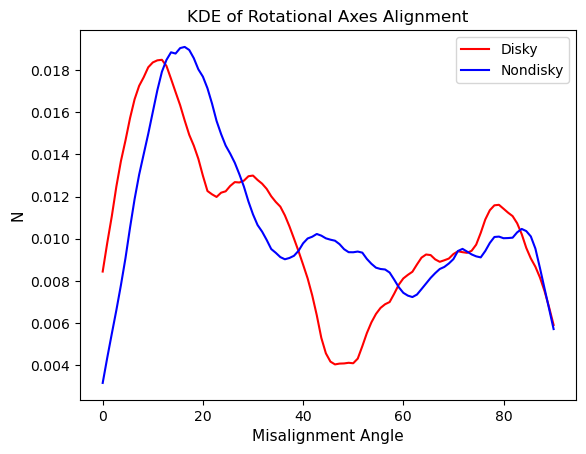

In [50]:
# Same KDE as above, but "folded" so that a 20deg and 160deg angle are identical

disky_angles_folded = []
nondisky_angles_folded = []
for angle in disky_angles:
    if angle >= 90:
        angle = 180 - angle
    disky_angles_folded.append(angle)
for angle in nondisky_angles:
    if angle >= 90:
        angle = 180 - angle
    nondisky_angles_folded.append(angle)
    
disky_angles_folded = np.array(disky_angles_folded)
nondisky_angles_folded = np.array(nondisky_angles_folded)
    
sum1 = np.sum(np.where(disky_angles_folded <= 20, np.ones(len(disky_angles_folded)), np.zeros(len(disky_angles_folded))))
sum1 += np.sum(np.where(nondisky_angles_folded <= 20, np.ones(len(nondisky_angles_folded)), np.zeros(len(nondisky_angles_folded))))
total = len(disky_angles_folded) + len(nondisky_angles_folded)
print(sum1/total)

h_disky = silverman(disky_angles_folded)
h_nondisky = silverman(nondisky_angles_folded)

x = np.linspace(0,90,100)

KDE_disky = KDE(x, h_disky, disky_angles_folded)
KDE_nondisky = KDE(x, h_nondisky, nondisky_angles_folded)

plt.plot(x,KDE_disky,'r',label='Disky')
plt.plot(x,KDE_nondisky,'b',label='Nondisky')
plt.legend()
plt.xlabel('Misalignment Angle',fontsize=11)
plt.ylabel('N',fontsize=11)
plt.title('KDE of Rotational Axes Alignment')

### Single Halo

In [5]:
# convienient to get all GrNr now
disky_GrNr = []
for subfindID in diskyIDs:
    disky_GrNr.append(il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])
    
nondisky_GrNr = []
for subfindID in nondiskyIDs:
    nondisky_GrNr.append(il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

In [7]:
# Makes a 3D plot of halo located at index idx of diskyGrNr (if disky = True, otherwise from nondiskyGrNr)
# Shows angular momentum axis in red, figure rotation axis in black

def plot3D(idx, disky = True):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    halo = idx
    if disky:
        GrNr = disky_GrNr[halo]
        subfindID = diskyIDs[halo]
    else:
        GrNr = nondisky_GrNr[halo]
        subfindID = nondiskyIDs[halo]
    
    spin_file = spin_path + 'GrNr_%d_snap_%d_99_lambda_prime_baryons.npy'%(GrNr,99)
    pattern_file = pattern_path + 'GrNr_%d_snap_%d_99_patternSpeeds.npy'%(GrNr,startSnap)
    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,startSnap)
    angle_file = anglePath + 'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap)

    if exists(spin_file) and exists(pattern_file) and exists(principal_file):
        spins = np.load(spin_file,allow_pickle=True)
        pattern_info = np.load(pattern_file, allow_pickle=True)
        pattern_info = dict(enumerate(pattern_info.flatten(),1))[1]
        principal_axes = np.load(principal_file,allow_pickle=True)
        angle = np.load(angle_file,allow_pickle=True)

        ### Translating coordinates to body frame and centering
        snap = 24 # most recent snap
        raxis = getRotationAxis(snap, pattern_info['startStop'], pattern_info['Raxis'])
        spin_axis = np.dot(inv(principal_axes[snap]), spins[-1]) # change snap depending on startSnap

        starPos = il.snapshot.loadSubhalo(basePath,99,subfindID,4,fields='Coordinates')
        x = []; y = []; z = []
        for pos in starPos:  
            starPos_body = np.dot(inv(principal_axes[snap]), pos)
            x.append(starPos_body[0])
            y.append(starPos_body[1])
            z.append(starPos_body[2])
        x_cent = np.where(np.abs(x - np.median(x)) < 15, (x - np.median(x)), [0])
        y_cent = np.where(np.abs(y - np.median(y)) < 15, (y - np.median(y)), [0])
        z_cent = np.where(np.abs(z - np.median(z)) < 15, (z - np.median(z)), [0])
        ax.scatter(x_cent,y_cent,z_cent,zorder=-1,alpha=0.2,s=5, edgecolor='none')
        ax.plot3D([0, 25*spin_axis[0]], [0,25*spin_axis[1]], [0,25*spin_axis[2]], color='r',zorder=3)
        ax.plot3D([0, 25*raxis[0]], [0,25*raxis[1]], [0,25*raxis[2]], color='k',zorder=3)
        ax.set_xlim([-15,15])
        ax.set_ylim([-15,15])
        ax.set_zlim([-15,15])

        plt.xlabel('x')
        plt.ylabel('y')
        title = 'GrNr: ' + str(GrNr) + ', \u03F4: ' + str(int(angle[-1])) + '\u00B0'
        plt.title(title)

In [32]:
# Makes a 2D histogram of halo located at index idx of diskyGrNr (if disky = True, otherwise from nondiskyGrNr)

def plot2D(idx, disky = True):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
    
    halo = idx
    if disky:
        GrNr = disky_GrNr[halo]
        subfindID = diskyIDs[halo]
        print(GrNr)
    else:
        GrNr = nondisky_GrNr[halo]
        subfindID = nondiskyIDs[halo]
        
    spin_file = spin_path + 'GrNr_%d_snap_%d_99_lambda_prime_baryons.npy'%(GrNr,99)
    pattern_file = pattern_path + 'GrNr_%d_snap_%d_99_patternSpeeds.npy'%(GrNr,startSnap)
    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,startSnap)
    angle_file = anglePath + 'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap)

    if exists(spin_file) and exists(pattern_file) and exists(principal_file):
        spins = np.load(spin_file,allow_pickle=True)
        pattern_info = np.load(pattern_file, allow_pickle=True)
        pattern_info = dict(enumerate(pattern_info.flatten(),1))[1]
        principal_axes = np.load(principal_file,allow_pickle=True)
        angle = np.load(angle_file,allow_pickle=True)

        ### Translating coordinates to body frame and centering
        snap = 24
        raxis = getRotationAxis(snap, pattern_info['startStop'], pattern_info['Raxis'])
        spin_axis = np.dot(inv(principal_axes[snap]), spins[-1]) # change snap depending on startSnap

        lim = 20 # SET TO DESIRED MAX RADIUS LIMIT FOR PLOT
        starPos = il.snapshot.loadSubhalo(basePath,99,subfindID,4,fields='Coordinates')
        x = []; y = []; z = []
        for pos in starPos:  
            starPos_body = np.dot(inv(principal_axes[snap]), pos)
            x.append(starPos_body[0])
            y.append(starPos_body[1])
            z.append(starPos_body[2])
        x_cent = np.where(np.abs(x - np.median(x)) < lim, (x - np.median(x)), [0])
        y_cent = np.where(np.abs(y - np.median(y)) < lim, (y - np.median(y)), [0])
        z_cent = np.where(np.abs(z - np.median(z)) < lim, (z - np.median(z)), [0])
        
        ax1.hist2d(x_cent, y_cent, bins=(80,80), norm=mpl.colors.LogNorm(),cmap=plt.cm.jet)
        ax1.set_facecolor("darkblue")
        ax1.set_xlim([-1*lim,lim])
        ax1.set_ylim([-1*lim,lim])
        ax1.set_xlabel('X [kpc]',fontsize=24)
        ax1.set_ylabel('Y [kpc]',fontsize=24)
        ax1.xaxis.set_tick_params(labelsize=18)
        ax1.yaxis.set_tick_params(labelsize=18)
        
        ax2.hist2d(x_cent, z_cent, bins=(80,80), norm=mpl.colors.LogNorm(), cmap=plt.cm.jet)
        ax2.set_facecolor("darkblue")
        ax2.set_xlim([-1*lim,lim])
        ax2.set_ylim([-1*lim,lim])
        ax2.set_xlabel('X [kpc]',fontsize=24)
        ax2.set_ylabel('Z [kpc]',fontsize=24)
        ax2.xaxis.set_tick_params(labelsize=18)
        ax2.yaxis.set_tick_params(labelsize=18)
        
        ax3.hist2d(y_cent, z_cent, bins=(80,80), norm=mpl.colors.LogNorm(), cmap=plt.cm.jet)
        ax3.set_facecolor("darkblue")
        ax3.set_xlim([-1*lim,lim])
        ax3.set_ylim([-1*lim,lim])
        ax3.set_xlabel('Y [kpc]',fontsize=24)
        ax3.set_ylabel('Z [kpc]',fontsize=24)
        ax3.xaxis.set_tick_params(labelsize=18)
        ax3.yaxis.set_tick_params(labelsize=18)
        
        print("misalignment angle: ", angle[-1])
        print("z-axis & rot. angle: ", np.degrees(np.arccos(raxis[2])))
        
    return fig